# Objective of the project 🚀

My objective is to create a machine learning model for object classification and then, try and compare it with a convolutional neural network (CNN) for images. For that, I will use Spark MLlib to train and evaluate the model. Secondly, create the CNN and compare both 🪐




# First Steps

## Download the data

The source of the data is: https://skyserver.sdss.org/CasJobs/
It is necessary to register and login a user to download the data you want. Then, you have to make a query specifying:
- Amount of rows
- Columns
- Where to keep the csv
- The database

As I want to get as much as possible data, I will not a maximum of rows.

I also add a "where" so I can get only data from planets, galaxies and stars:
- type = 3: Galaxies
- type = 6: Stars

and I downloaded the dataset to start working with it.

<img src="/home/haizeagonzalez/myproject/bigDataAstronomy/notebookImages/img1.png">

## Understanding the data

The columns we have are:
- objID: Unique identifier of the object → TYPE bigInt
- ra: Right ascension → TYPE float
- dec: Declination → TYPE float
- petroRad: Petrosian radius, used to know the size of galaxies in astronomical pictures. It is the amount of light that a galaxy emits in a sepecific radius. Very used because it is independent of the distance and brightness. We use different photometric filters:
    - petroRad_u: Near-ultraviolet
    - petroRad_g: Blue-Green
    - petroRad_r: Red
    - petroRad_i: Near-infrared
    - petroRad_z: Deeper infrared
 → TYPE: Real

- modelMag: Brightness measure adjusted to a galaxy model. Usual for galaxies. Also for all filters (u, g, r, i and z) → TYPE Real
- psfMag: Brightness measure based on the point source light profile. Usual for stars. Also for all filters (u, g, r, i and z) → TYPE Real
- u_g: (modelMag_u - modelMag_g)
- g_r: (modelMag_g - modelMag_r)
- r_i: (modelMag_r - modelMag_i)
- i_z: (modelMag_i - modelMag_z)
- fracDeV: The amount of brightness that the object has in the De Vaucouleurs profile. Also for all filters (u, g, r, i and z) → TYPE Real
- flags: Bit comination that explains different characteristics of the object. If we convert it to binary and check SDSS documentarion, we get a meaning for each bit → TYPE bigInt
- clean: Indicator that tell us if the object was cleaned → TYPE int



### What for?

PetroRad:
- Stars: Small and constant in all filters.
- Galaxies: Bigger and variates depending on the wavelengths.

ModelMag and psfMag:
- In the red filter:
    - Stars: modelMag_r ≈ psfMag_r
    - Galaxies: modelMag_r > psfMag_r
- In other filers:
    - Galaxies are usuarlly more red  (modelMag_g - modelMag_r is big).
    - Stars has different colors depending on their type.

fracDeV:
- Stars: fracDeV ≈ 0.
- Galaxies: fracDeV ≈ 1 (eliptic) or fracDeV < 1 (espiral).



# Spark

## Spark configuration

First, we need to create a spark sesion in case there is no one or get if there exists: "getOrCreate". I also decided to create a log in case there is any error during the process.

In [22]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("bigDataAstronomyProject") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "1") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Then, we need to read de csv data.

In [23]:
path = "/home/haizeagonzalez/bigDataProject/primaryObjs.csv"
path2 = "/home/haizeagonzalez/myproject/primaryObjs.csv"

df = spark.read.csv(path2, header=True)

Now, we are going to check if the data is correctly loaded.

In [24]:
df.show()

+-------------------+----------------+------------------+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---------+---------+-------------+----------+---------+---------+---------+---------+----------+---------------+-----+
|              objID|              ra|               dec|type|petroRad_u|petroRad_g|petroRad_r|petroRad_i|petroRad_z|modelMag_u|modelMag_g|modelMag_r|modelMag_i|modelMag_z|psfMag_u|psfMag_g|psfMag_r|psfMag_i|psfMag_z|      u_g|      g_r|          r_i|       i_z|fracDeV_u|fracDeV_g|fracDeV_r|fracDeV_i| fracDeV_z|          flags|clean|
+-------------------+----------------+------------------+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---------+---------+-------------+----------+---------+---------+---------+---------+----------+---------------

The schema and the chacacteristics of the data.

In [25]:
df.printSchema()

root
 |-- objID: string (nullable = true)
 |-- ra: string (nullable = true)
 |-- dec: string (nullable = true)
 |-- type: string (nullable = true)
 |-- petroRad_u: string (nullable = true)
 |-- petroRad_g: string (nullable = true)
 |-- petroRad_r: string (nullable = true)
 |-- petroRad_i: string (nullable = true)
 |-- petroRad_z: string (nullable = true)
 |-- modelMag_u: string (nullable = true)
 |-- modelMag_g: string (nullable = true)
 |-- modelMag_r: string (nullable = true)
 |-- modelMag_i: string (nullable = true)
 |-- modelMag_z: string (nullable = true)
 |-- psfMag_u: string (nullable = true)
 |-- psfMag_g: string (nullable = true)
 |-- psfMag_r: string (nullable = true)
 |-- psfMag_i: string (nullable = true)
 |-- psfMag_z: string (nullable = true)
 |-- u_g: string (nullable = true)
 |-- g_r: string (nullable = true)
 |-- r_i: string (nullable = true)
 |-- i_z: string (nullable = true)
 |-- fracDeV_u: string (nullable = true)
 |-- fracDeV_g: string (nullable = true)
 |-- fracDe

As all columns are string, we need to convert them into their type. For that:

In [26]:
from pyspark.sql.functions import col

df = df.withColumn("objID", col("objID").cast("long")) \
       .withColumn("ra", col("ra").cast("float")) \
       .withColumn("dec", col("dec").cast("float")) \
       .withColumn("petroRad_u", col("petroRad_u").cast("float")) \
       .withColumn("petroRad_g", col("petroRad_g").cast("float")) \
       .withColumn("petroRad_r", col("petroRad_r").cast("float")) \
       .withColumn("petroRad_i", col("petroRad_i").cast("float")) \
       .withColumn("petroRad_z", col("petroRad_z").cast("float")) \
       .withColumn("modelMag_u", col("modelMag_u").cast("float")) \
       .withColumn("modelMag_g", col("modelMag_g").cast("float")) \
       .withColumn("modelMag_r", col("modelMag_r").cast("float")) \
       .withColumn("modelMag_i", col("modelMag_i").cast("float")) \
       .withColumn("modelMag_z", col("modelMag_z").cast("float")) \
       .withColumn("psfMag_u", col("psfMag_u").cast("float")) \
       .withColumn("psfMag_g", col("psfMag_g").cast("float")) \
       .withColumn("psfMag_r", col("psfMag_r").cast("float")) \
       .withColumn("psfMag_i", col("psfMag_i").cast("float")) \
       .withColumn("psfMag_z", col("psfMag_z").cast("float")) \
       .withColumn("u_g", col("u_g").cast("float")) \
       .withColumn("g_r", col("g_r").cast("float")) \
       .withColumn("r_i", col("r_i").cast("float")) \
       .withColumn("i_z", col("i_z").cast("float")) \
       .withColumn("fracDeV_u", col("fracDeV_u").cast("float")) \
       .withColumn("fracDeV_g", col("fracDeV_g").cast("float")) \
       .withColumn("fracDeV_r", col("fracDeV_r").cast("float")) \
       .withColumn("fracDeV_i", col("fracDeV_i").cast("float")) \
       .withColumn("fracDeV_z", col("fracDeV_z").cast("float")) \
       .withColumn("flags", col("flags").cast("long")) \
       .withColumn("clean", col("clean").cast("int"))

df.printSchema()

root
 |-- objID: long (nullable = true)
 |-- ra: float (nullable = true)
 |-- dec: float (nullable = true)
 |-- type: string (nullable = true)
 |-- petroRad_u: float (nullable = true)
 |-- petroRad_g: float (nullable = true)
 |-- petroRad_r: float (nullable = true)
 |-- petroRad_i: float (nullable = true)
 |-- petroRad_z: float (nullable = true)
 |-- modelMag_u: float (nullable = true)
 |-- modelMag_g: float (nullable = true)
 |-- modelMag_r: float (nullable = true)
 |-- modelMag_i: float (nullable = true)
 |-- modelMag_z: float (nullable = true)
 |-- psfMag_u: float (nullable = true)
 |-- psfMag_g: float (nullable = true)
 |-- psfMag_r: float (nullable = true)
 |-- psfMag_i: float (nullable = true)
 |-- psfMag_z: float (nullable = true)
 |-- u_g: float (nullable = true)
 |-- g_r: float (nullable = true)
 |-- r_i: float (nullable = true)
 |-- i_z: float (nullable = true)
 |-- fracDeV_u: float (nullable = true)
 |-- fracDeV_g: float (nullable = true)
 |-- fracDeV_r: float (nullable = tr

Now that we have all the structure, we are going to explore and clean the data.

## Data cleaning

In principle, the data is cleaned because we get it from CasJobs and we apply clear filter to get good data. 
However, we are going to check whether there is any null value and the amount of galaxies and stars.  

In [27]:
from pyspark.sql.functions import col, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+---+---+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---+---+---+---+---------+---------+---------+---------+---------+-----+-----+
|objID| ra|dec|type|petroRad_u|petroRad_g|petroRad_r|petroRad_i|petroRad_z|modelMag_u|modelMag_g|modelMag_r|modelMag_i|modelMag_z|psfMag_u|psfMag_g|psfMag_r|psfMag_i|psfMag_z|u_g|g_r|r_i|i_z|fracDeV_u|fracDeV_g|fracDeV_r|fracDeV_i|fracDeV_z|flags|clean|
+-----+---+---+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---+---+---+---+---------+---------+---------+---------+---------+-----+-----+
|    0|  0|  0|   0|         0|         0|         0|         0|         0|         0|         0|         0|         0|         0|       0|       0|       0|       0|       0|  0|  0|  0|  0|        0|        0|        0|        0|       

In [28]:
df.head(3)

[Row(objID=1237648704596673591, ra=228.13320922851562, dec=0.1894191950559616, type='3', petroRad_u=2.969285011291504, petroRad_g=2.9693689346313477, petroRad_r=2.220518112182617, petroRad_i=1.2497830390930176, petroRad_z=1.6223200559616089, modelMag_u=23.71841049194336, modelMag_g=23.551189422607422, modelMag_r=21.70663070678711, modelMag_i=21.070819854736328, modelMag_z=20.949180603027344, psfMag_u=23.715309143066406, psfMag_g=24.258529663085938, psfMag_r=22.411449432373047, psfMag_i=21.533750534057617, psfMag_z=21.45539093017578, u_g=0.16722489893436432, g_r=1.8445570468902588, r_i=0.635805070400238, i_z=0.12164119631052017, fracDeV_u=1.0, fracDeV_g=0.0, fracDeV_r=1.0, fracDeV_i=1.0, fracDeV_z=1.0, flags=316730484195600, clean=1),
 Row(objID=1237648704596673595, ra=228.13265991210938, dec=0.15501631796360016, type='3', petroRad_u=2.969285011291504, petroRad_g=1.167544960975647, petroRad_r=1.7131999731063843, petroRad_i=4.19382905960083, petroRad_z=1.5816819667816162, modelMag_u=26.2

In [29]:
df.groupBy("type").count().show()

+----+-------+
|type|  count|
+----+-------+
|   3| 986539|
|   6|2513461|
+----+-------+



As we can see, there is no null values and the amount of galaxies are less than the amount of stars, which make sense. However, this can affect the model so we are going to balance the data.

First, as it is a binary classification, we will update stars to 0 and galaxies to 1.

In [30]:
df = df.withColumn("type", when(col("type") == 3,1).otherwise(0))

In [31]:
df_stars = df.filter(df["type"] == 0)
df_galaxies = df.filter(df["type"] == 1)

#Print to know the conversion is correctly done
df_stars.show(5)
df_galaxies.show(5)

+-------------------+---------+----------+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+--------------+-----+
|              objID|       ra|       dec|type|petroRad_u|petroRad_g|petroRad_r|petroRad_i|petroRad_z|modelMag_u|modelMag_g|modelMag_r|modelMag_i|modelMag_z|psfMag_u|psfMag_g|psfMag_r|psfMag_i|psfMag_z|     u_g|     g_r|      r_i|      i_z|fracDeV_u|fracDeV_g|fracDeV_r|fracDeV_i|fracDeV_z|         flags|clean|
+-------------------+---------+----------+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+--------------+-----+
|1237648704596673596|228.13359|0.06267392|   0|  7.357505|  1.31

As for the supervised machine model we won't use objID, ra, dec, flags and clean columns, we are going to remove them. 

In [32]:
df_ml_model = df.select("type", "petroRad_u", "petroRad_g", "petroRad_r", "petroRad_i", "petroRad_z",
                        "modelMag_u", "modelMag_g", "modelMag_r", "modelMag_i", "modelMag_z",
                        "psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z",
                        "u_g", "g_r", "r_i", "i_z",
                        "fracDeV_u", "fracDeV_g", "fracDeV_r", "fracDeV_i", "fracDeV_z")

df_ml_model.printSchema()

root
 |-- type: integer (nullable = false)
 |-- petroRad_u: float (nullable = true)
 |-- petroRad_g: float (nullable = true)
 |-- petroRad_r: float (nullable = true)
 |-- petroRad_i: float (nullable = true)
 |-- petroRad_z: float (nullable = true)
 |-- modelMag_u: float (nullable = true)
 |-- modelMag_g: float (nullable = true)
 |-- modelMag_r: float (nullable = true)
 |-- modelMag_i: float (nullable = true)
 |-- modelMag_z: float (nullable = true)
 |-- psfMag_u: float (nullable = true)
 |-- psfMag_g: float (nullable = true)
 |-- psfMag_r: float (nullable = true)
 |-- psfMag_i: float (nullable = true)
 |-- psfMag_z: float (nullable = true)
 |-- u_g: float (nullable = true)
 |-- g_r: float (nullable = true)
 |-- r_i: float (nullable = true)
 |-- i_z: float (nullable = true)
 |-- fracDeV_u: float (nullable = true)
 |-- fracDeV_g: float (nullable = true)
 |-- fracDeV_r: float (nullable = true)
 |-- fracDeV_i: float (nullable = true)
 |-- fracDeV_z: float (nullable = true)



## Spark ML

As our objective is to create a machine learning model, we need to convert the data in a correct format: Vectors.

In [33]:
from pyspark.ml.feature import VectorAssembler

features = df_ml_model.columns[1:] #We don't get the type beacuse is the result we want to get.
assembler = VectorAssembler(inputCols = features, outputCol = "features") #Convert features list as a vector
df_ml_model = assembler.transform(df_ml_model) #Apply transformation
df_ml_model = df_ml_model.select("features", "type")

df_ml_model.head(5)

[Row(features=DenseVector([2.9693, 2.9694, 2.2205, 1.2498, 1.6223, 23.7184, 23.5512, 21.7066, 21.0708, 20.9492, 23.7153, 24.2585, 22.4114, 21.5338, 21.4554, 0.1672, 1.8446, 0.6358, 0.1216, 1.0, 0.0, 1.0, 1.0, 1.0]), type=1),
 Row(features=DenseVector([2.9693, 1.1675, 1.7132, 4.1938, 1.5817, 26.2304, 23.0677, 21.6006, 21.0439, 20.495, 25.8125, 23.3006, 22.1662, 21.5961, 20.9335, 3.1627, 1.467, 0.5567, 0.5489, 0.0, 1.0, 0.5398, 1.0, 0.0]), type=1),
 Row(features=DenseVector([7.3575, 1.3172, 1.0486, 0.9809, 0.9447, 23.2214, 21.6643, 20.2941, 19.1296, 18.5325, 23.2969, 21.694, 20.3222, 19.1463, 18.5552, 1.5571, 1.3702, 1.1645, 0.597, 1.0, 1.0, 1.0, 0.0, 0.0]), type=0),
 Row(features=DenseVector([4.5831, 1.8019, 1.7124, 1.6114, 1.6939, 24.1385, 22.0195, 21.3337, 21.0293, 21.2284, 24.3523, 22.5369, 21.9557, 21.7626, 21.684, 2.119, 0.6858, 0.3044, -0.1991, 0.2213, 0.0, 0.0, 0.0, 0.0]), type=1),
 Row(features=DenseVector([7.3575, 1.2759, 1.898, 2.2196, 2.8063, 25.9456, 22.6729, 20.7697, 20.014

Now, we are going to divide the dataset into train and test, so we can get the accuracy of the model.

In [34]:
train_data, test_data = df_ml_model.randomSplit([0.8, 0.2], seed = 132)

We are going to try different models to check which is the best for our case.

In [67]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC

#Define different models
models = {
    "Logistic Regression": LogisticRegression(labelCol="type", featuresCol="features"),
    "Decision Tree": DecisionTreeClassifier(labelCol="type", featuresCol="features"),
    "Random Forest": RandomForestClassifier(labelCol="type", featuresCol="features", numTrees=5),
    "Gradient Boosted Trees": GBTClassifier(labelCol="type", featuresCol="features"),
    "Linear SVM": LinearSVC(labelCol="type", featuresCol="features")
}


#lr = LogisticRegression(labelCol="type", featuresCol="features")
#lr_model = lr.fit(train_data)
#predictions = lr_model.transform(test_data)


Now, we are going to calculate the **AUC evaluator** for model and look how well they are doing. I decided to use AUC because it is a good technique to use for binary classification, especially when classes are unbalanced.

Remember that the ROC curve gives a visual representation between the true prositive rate and false positive rate at different thresholds. So, it tell us how well the model can detect true positive and avoid false positives. Moreover, AUC is one scalar value from 0 to  that tell how the model performs globally. AUC represents the area beneath the curve.
- AUC = 0.5 ⭢ Random Predictions
- AUC > 0.5 ⭢ Increasingly good predictions
- AUC = 1 ⭢ Perfect predictions



<img src="/home/haizeagonzalez/myproject/bigDataAstronomy/notebookImages/img2.png">

In [68]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


evaluator = BinaryClassificationEvaluator(labelCol="type", metricName="areaUnderROC")

for name, model in models.items():
    model_trained = model.fit(train_data)
    predictions = model_trained.transform(test_data)
    auc = evaluator.evaluate(predictions)
    print(f"{name}: AUC = {auc:.4f}")


Logistic Regression: AUC = 0.9920


Decision Tree: AUC = 0.7914


Random Forest: AUC = 0.9731


Gradient Boosted Trees: AUC = 0.9872


Linear SVM: AUC = 0.9887


El modelo Linear SVM no tiene la columna 'probability', no se incluirá en el gráfico.


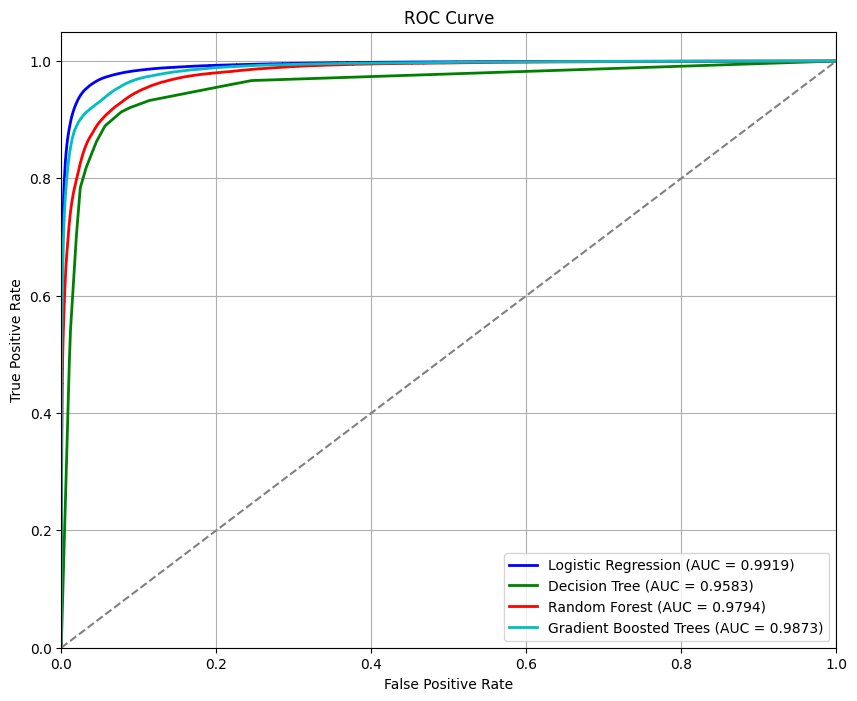

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#Create the figure
plt.figure(figsize=(10, 8))

#Different colors for the different models
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

#For each model compute the AUC
for idx, (name, model) in enumerate(models.items()):
    model_trained = model.fit(train_data)
    predictions = model_trained.transform(test_data) #Predicted class (0 or 1)

    #Check if the model has "probability" column because some of them (SVG for example) do not
    if "probability" in predictions.columns:
        #Get the whole probability vector, convert it into rdd and select the probability for the positive (real) prediction
        prob_positives = predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
        #Get the label for each prediction
        true_labels = predictions.select("type").rdd.map(lambda row: row[0]).collect()

        #Calculate ROC curve
        fpr, tpr, _ = roc_curve(true_labels, prob_positives)
        roc_auc = auc(fpr, tpr)

        #Plot it
        plt.plot(fpr, tpr, color=colors[idx % len(colors)], lw=2, label=f'{name} (AUC = {roc_auc:.4f})')
    else:
        print(f"El modelo {name} no tiene la columna 'probability', no se incluirá en el gráfico.")

#Different parameters to personalize the plot
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  #Diagonal line of "random"
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()

plt.show()

In [21]:
train_predictions.groupBy("type", "prediction").count().show()
test_predictions.groupBy("type", "prediction").count().show()

+----+----------+-------+
|type|prediction|  count|
+----+----------+-------+
|   1|       0.0|  32290|
|   0|       0.0| 722858|
|   1|       1.0|1977943|
|   0|       1.0|  66487|
+----+----------+-------+



+----+----------+------+
|type|prediction| count|
+----+----------+------+
|   1|       0.0|  8297|
|   0|       0.0|180740|
|   1|       1.0|494931|
|   0|       1.0| 16454|
+----+----------+------+



AUC en entrenamiento y prueba:
Tienes un AUC muy alto (0.9918 en entrenamiento y 0.9919 en prueba), lo cual es excelente y sugiere que tu modelo está prediciendo bien. Sin embargo, el hecho de que AUC en entrenamiento y prueba sean tan similares es una buena señal de que no hay overfitting en términos de rendimiento global.


Matriz de Confusión: La matriz de confusión muestra que el modelo tiene un desbalance significativo entre las clases. Aquí hay algunos puntos clave:

Predicciones clase 0 (mayoría):
El modelo predice 0 en casi todos los casos (más de 720,000 para 0.0 en lugar de 1.0).
Clase 0: Muy bien predicha, pero alta tasa de falsos positivos (66487 predicciones 1.0 cuando deberían ser 0).
Predicciones clase 1 (minoría):
Predice 1 correctamente en muchos casos (casi 2 millones de predicciones de 1.0), pero hay algunos falsos negativos (8297 predicciones 0.0 cuando deberían ser 1).
Conclusión sobre la matriz de confusión:

El modelo predice mayormente la clase 0, lo que podría indicar un desbalance de clases (más ejemplos de clase 0 que de clase 1).
Si la clase minoritaria (1) tiene menos ejemplos, el modelo podría estar favoreciendo la clase mayoritaria, lo que no es necesariamente un problema, pero puede ser útil ajustarlo.

AUC de entrenamiento ≈ AUC de prueba: No parece haber overfitting ya que la diferencia entre el AUC en entrenamiento y prueba es muy pequeña.

Desbalance de clases: Podría ser que el modelo esté demasiado inclinado a predecir la clase mayoritaria (0), lo cual es común en datasets desbalanceados.

Posibles mejoras: Regularizacion

In [22]:
lr_with_reg = LogisticRegression(labelCol="type", featuresCol="features", maxIter=100, regParam=0.1)  # Puedes ajustar regParam
model_with_reg = lr_with_reg.fit(train_data)

# Evaluar el modelo con regularización
predictions_with_reg = model_with_reg.transform(test_data)
auc_with_reg = evaluator2.evaluate(predictions_with_reg)
print(f"AUC con regularización: {auc_with_reg:.4f}")

AUC con regularización: 0.9056


# Images

As I need also de images, I have downloaded from https://skyserver.sdss.org/dr18, specifying with a request:
- the location of the object (with right ascension (RA) and declination (dec))
- the zoom of the picture (scale)
- the dimmensions of the photo (with and height)